Get the implicit utility function.

In [1]:
struct Calibration
    σ::Float64           #elasticity of relative demand with respect to price         
    γ::Vector{Float64}   #intensity in each good
    ϵ::Vector{Float64}   #elasticity of relative demand with respect to income in luxury good sector
    κ::Vector{Float64}   #For Stone and Geary
    p::Vector{Float64}
    g::Vector{Float64}
end


In [7]:
cal = Calibration(
    0.5,                    # sigma=0.5 completementary goods
    [1/3, 1/3, 1/3],        #intensity
    [0.8, 1.0, 1.2],       #ELASTICITIES
    [0.05, 0.03, 0.02],     #For Stone and Geary
    [100.0, 100.0, 100.0],
    [1.05, 1.02, 1.01]
)

Calibration(0.5, [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], [0.8, 1.0, 1.2], [0.05, 0.03, 0.02], [100.0, 100.0, 100.0], [1.05, 1.02, 1.01])

In [8]:
ρ=(cal.σ-1)/cal.σ

-1.0

# CES utility function

$$E=\sum^{\mathcal{I}}_{i=1}p_iC_i$$

$$C_i^*= \left(\frac{\gamma_i}{p_i}\right)^\sigma \frac{E}{\sum^{\mathcal{I}}_{i=1}\gamma_i^\sigma p_i^{1-\sigma}}$$

$$U(C_1^*,...,C_I^*)=\left[\sum^{\mathcal{I}}_{i=1}\gamma_iC_i^{* \rho} \right]^{\frac{1}{\rho}}

In [11]:
#Function CES
function CES_Utility(C::Vector{Float64}; cal=cal)
    #Budget, expenditure function
    E=sum(cal.p[i]*C[i] for i = 1:length(C))
    
    #CONS
    C1=(cal.γ[1]/cal.p[1])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*cal.p[i]^(1-cal.σ) for i=1:length(cal.γ)))
    C2=(cal.γ[2]/cal.p[2])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*cal.p[i]^(1-cal.σ) for i=1:length(cal.γ)))
    C3=(cal.γ[3]/cal.p[3])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*cal.p[i]^(1-cal.σ) for i=1:length(cal.γ)))

    CB=[C1 C2 C3]
    U=sum(cal.γ[i]*CB[i]^ρ for i=1:length(CB))^(1/ρ)


    #SHARE
    ω_p=(cal.p[1]*C1)/E
    ω_n=(cal.p[2]*C2)/E
    ω_l=(cal.p[3]*C3)/E

    return [U, E, C, [C1, C2, C3], [ω_p, ω_n, ω_l]]
end

CES_Utility (generic function with 1 method)

In [12]:
U=CES_Utility([20.0,5.0,30.0])

5-element Vector{Any}:
   18.333333333333336
 5500.0
     [20.0, 5.0, 30.0]
     [18.333333333333336, 18.333333333333336, 18.333333333333336]
     [0.33333333333333337, 0.33333333333333337, 0.33333333333333337]

In [14]:
#Insert an Endowment bundle
U=CES_Utility([20.0,5.0,30.0])
println("Utility level reached ", U[1])

println("Expenditure/Wealth level ", U[2])
println("Initial Endowment ", U[3])
println("Optimal Endowment given prices ", U[4])
println("Expenditure share per good ", U[5])

Utility level reached 18.333333333333336
Expenditure/Wealth level 5500.0
Initial Endowment [20.0, 5.0, 30.0]
Optimal Endowment given prices [18.333333333333336, 18.333333333333336, 18.333333333333336]
Expenditure share per good [0.33333333333333337, 0.33333333333333337, 0.33333333333333337]


In [25]:
u=[]
C=[]

scale=10.0
for i = 1:scale
    for j=1:scale
        for k =1:scale
            res =CES_Utility([i,j,k])
            u=push!(u,res[1])
            C=push!(C,[i j k])
        end
    end
end

[u C]


1000×2 Matrix{Any}:
  1.0      [1.0 1.0 1.0]
  1.33333  [1.0 1.0 2.0]
  1.66667  [1.0 1.0 3.0]
  2.0      [1.0 1.0 4.0]
  2.33333  [1.0 1.0 5.0]
  2.66667  [1.0 1.0 6.0]
  3.0      [1.0 1.0 7.0]
  3.33333  [1.0 1.0 8.0]
  3.66667  [1.0 1.0 9.0]
  4.0      [1.0 1.0 10.0]
  ⋮        
  7.33333  [10.0 10.0 2.0]
  7.66667  [10.0 10.0 3.0]
  8.0      [10.0 10.0 4.0]
  8.33333  [10.0 10.0 5.0]
  8.66667  [10.0 10.0 6.0]
  9.0      [10.0 10.0 7.0]
  9.33333  [10.0 10.0 8.0]
  9.66667  [10.0 10.0 9.0]
 10.0      [10.0 10.0 10.0]

# Stone and Geary

In [7]:
#Function Stone and Geary
function SG(C::Vector{Int64}, cal)
    U=sum(cal.γ[i]*(C[i]+cal.κ[i])^ρ for i=1:length(C))^(1/ρ)
    return U
end

SG (generic function with 1 method)

# Non Homothetic Utility function

In [15]:
using NLsolve
u=1

#UTILITY LEVEL for a given C
function solvingNH(u, C::Vector{Float64}, cal)
    out=sum(cal.γ[i]^(1/cal.σ)*(C[i]/u^(cal.ϵ[i]))^ρ for i=1:length(C))-1
    return out
end

function NHUtility(u,C::Vector{Float64};cal=cal,tol=1e-10,T=1000)
    u=1.0
    res = nlsolve(u->[solvingNH(u[1], C, cal)], [1.0])
    E=sum(cal.p[i]*C[i] for i=1:length(C))
    #Utility level for given C
    U=res.zero[1]
    #1st utility for given endowment level
    Uinit=res.zero[1]

    #Minimum expenditure for the utility at given endowment level
    miniEforUinit=sum(cal.γ[i]*U^(cal.ϵ[i]*(1-cal.σ)) * (cal.p[i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
    
    #Optimal Demand with income effect
    C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/E)^(-cal.σ)
    C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/E)^(-cal.σ)
    C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/E)^(-cal.σ)

    #Expenditure share with income effect
    ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/E)^(1-cal.σ)
    ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/E)^(1-cal.σ)
    ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/E)^(1-cal.σ)

    #Initial Demand for given endowment level, U initial and minimum expenditure level
    Cinit=[C1,C2,C3]
    ω_init=[ω_p, ω_n, ω_l]

    #Optimal update for demand
    C=[C1,C2,C3]
    ω=[ω_p, ω_n, ω_l]

    #Non homothetic preferences updated expenditure since we still have some wealth unused.
    ExpNH=sum(cal.p[i]*C[i] for i=1:length(C))

    #Non homothetic preferences Expenditure have to coincide with the endowment level wealth.
    if abs(E-ExpNH)>tol
        for j=1:T
            res=nlsolve(u->[solvingNH(u[1], C, cal)], [1.0])
            U=res.zero[1]
            
            #DEMAND
            C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/E)^(-cal.σ)
            C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/E)^(-cal.σ)
            C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/E)^(-cal.σ)

            #SHARE
            ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/E)^(1-cal.σ)
            ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/E)^(1-cal.σ)
            ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/E)^(1-cal.σ)

            C=[C1, C2, C3]
            ω=[ω_p, ω_n, ω_l]
    
            ExpNH=sum(cal.p[i]*C[i] for i =1:length(C)) 
        end
        return [U, Uinit, miniEforUinit, E, ExpNH, C, Cinit, ω, ω_init]
    end
end

NHUtility (generic function with 1 method)

In [16]:
NHU=NHUtility(u,[2.0, 2.0, 2.0])
println("NH pref optimal utility level with no waste ", NHU[1])
println("Utility level reached at given endowment ", NHU[2])
println("Above can be reached with minimal cost ", NHU[3])
println("But we have to spend all the wealth so that there is no waste ", NHU[4])
println("Hence NH expenditure will coincide with the wealth ", NHU[5])
println("With bundle (updated) ", NHU[6])
println("Whereas endowment level utility can be reached with this bundle ", NHU[7])
println("Optimal share with no waste ", NHU[8])
println("Optimal share initial with waste ", NHU[9])

NH pref optimal utility level with no waste 5.876177496473199
Utility level reached at given endowment 5.761957767564521
Above can be reached with minimal cost 588.0676236604951
But we have to spend all the wealth so that there is no waste 600.0
Hence NH expenditure will coincide with the wealth 600.0000000000006
With bundle (updated) [1.6580298031239071, 1.9792553307533283, 2.3627148661227704]
Whereas endowment level utility can be reached with this bundle [1.6450624858417935, 1.9599247889590934, 2.335051228410158]
Optimal share with no waste [0.27633830052065117, 0.329875888458888, 0.39378581102046173]
Optimal share initial with waste [0.27417708097363225, 0.32665413149318223, 0.3891752047350263]


In [18]:
u=[]
C=[]

scale=5.0
for i = 1:scale
    for j=1:scale
        for k =1:scale
            res =NHUtility(u,[i,j,k])
            u=push!(u,res[1])
            C=push!(C,[i j k])
        end
    end
end

NH=[u C]


125×2 Matrix{Any}:
  2.97633  [1.0 1.0 1.0]
  3.95007  [1.0 1.0 2.0]
  4.91634  [1.0 1.0 3.0]
  5.87618  [1.0 1.0 4.0]
  6.83034  [1.0 1.0 5.0]
  3.95007  [1.0 2.0 1.0]
  4.91634  [1.0 2.0 2.0]
  5.87618  [1.0 2.0 3.0]
  6.83034  [1.0 2.0 4.0]
  7.77942  [1.0 2.0 5.0]
  ⋮        
 10.6006   [5.0 4.0 2.0]
 11.5333   [5.0 4.0 3.0]
 12.4627   [5.0 4.0 4.0]
 13.389    [5.0 4.0 5.0]
 10.6006   [5.0 5.0 1.0]
 11.5333   [5.0 5.0 2.0]
 12.4627   [5.0 5.0 3.0]
 13.389    [5.0 5.0 4.0]
 14.3122   [5.0 5.0 5.0]

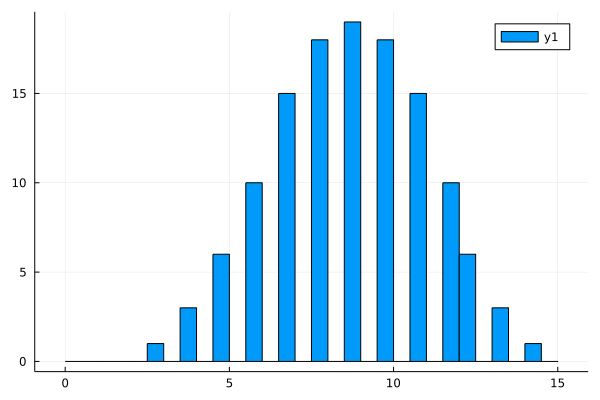

In [23]:
using Plots, Distributions
histogram(NH[:,1]; bins = 0:0.5:15)


In [17]:
#Price dynamics
using Plots, DataFrames

function pricedynamics(T::Int64;cal=cal,N=3)
#Time and number of household considered
    #Get our price level dynamics
    shock_size=5
    index=100.0 
    pp=[cal.p[1]]  #price primary
    pn=[cal.p[2]]  #price normal
    pl=[cal.p[3]]  #price luxury
    agg=[1/N*(cal.p[1]+cal.p[2]+cal.p[3])] #aggregate price with homothetic

    for t=1:T-1
        p_p=100*cal.g[1]^(t)+shock_size*randn() # price dynamics of primary goods
        p_n=100*cal.g[2]^(t)+shock_size*randn() # price dynamics of normal goods
        p_l=100*cal.g[3]^(t)+shock_size*randn()
        agg_p=0.333*p_p+0.333*p_n+0.333*p_l #share coming from homothetic consumption bundle

        pp=push!(pp,p_p)
        pn=push!(pn,p_n)
        pl=push!(pl,p_l)
        agg=push!(agg,agg_p)
    end

    pricesplot = [pp pn pl agg]
    return plot(pricesplot, title="Prices dynamics", label=["Primary" "Normal" "Luxury" "Aggregate"], lw=2)
end
    

pricedynamics (generic function with 1 method)

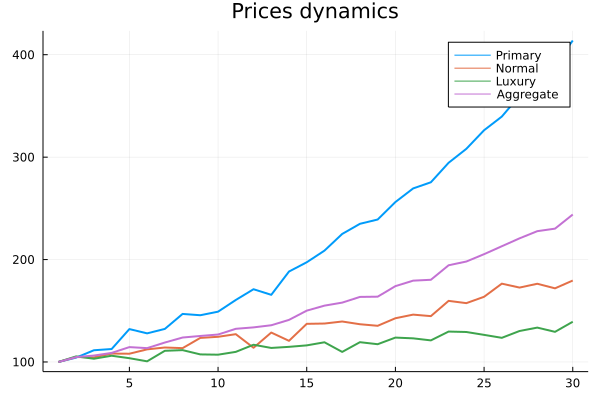

In [18]:
pricedynamics(30)

In [19]:
function prices(T::Int64 ;cal=cal)
    #Prices normalized at date t=1
    pp=[cal.p[1]]  #price primary
    pn=[cal.p[2]]  #price normal
    pl=[cal.p[3]]  #price luxury
    #Relative prices
    pnp_r=[1.0]
    pnl_r=[1.0]
    #AR(1)
    shock_size=5

    for t=1:T-1
        p_p=100*cal.g[1]^(t)+shock_size*randn() # price dynamics of primary goods
        p_n=100*cal.g[2]^(t)+shock_size*randn() # price dynamics of normal goods
        p_l=100*cal.g[3]^(t)+shock_size*randn()

        pnp=p_p/p_n
        pnl=p_l/p_n

        #for matrix
        pp=push!(pp,p_p)
        pn=push!(pn,p_n)
        pl=push!(pl,p_l)

        pnp_r=push!(pnp_r,pnp)
        pnl_r=push!(pnl_r,pnl)
        
    end
    return [pp pn pl pnp_r pnl_r]
end

T=30
p=prices(T)

data=DataFrame(p,:auto)

rename!(data,[:"Primary P",:"Normal P", :"LuxuryP",:"Relative P/N",:"Relative L/N"])

,Primary P,Normal P,LuxuryP,Relative P/N,Relative L/N
,Float64,Float64,Float64,Float64,Float64
1,100.0,100.0,100.0,1.0,1.0
2,105.866,110.056,103.295,0.961934,0.938569
3,109.453,97.769,101.197,1.11951,1.03506
4,122.914,110.555,96.2344,1.11178,0.870463
5,125.989,109.179,102.498,1.15397,0.938811
6,128.976,119.119,106.609,1.08275,0.89498
7,131.399,117.828,118.208,1.11517,1.00322
8,143.252,116.024,108.421,1.23468,0.934474
9,145.58,108.135,107.211,1.34628,0.991457


In [20]:
p

30×5 Matrix{Float64}:
 100.0    100.0    100.0     1.0       1.0
 105.866  110.056  103.295   0.961934  0.938569
 109.453   97.769  101.197   1.11951   1.03506
 122.914  110.555   96.2344  1.11178   0.870463
 125.989  109.179  102.498   1.15397   0.938811
 128.976  119.119  106.609   1.08275   0.89498
 131.399  117.828  118.208   1.11517   1.00322
 143.252  116.024  108.421   1.23468   0.934474
 145.58   108.135  107.211   1.34628   0.991457
 160.825  116.934  110.831   1.37535   0.947807
   ⋮                                   
 281.11   148.145  127.019   1.89753   0.857393
 286.5    161.146  128.372   1.77789   0.796617
 313.967  146.648  124.005   2.14096   0.845599
 307.199  157.55   124.643   1.94984   0.791132
 329.914  160.203  132.47    2.05935   0.826889
 359.67   170.867  130.635   2.10497   0.764545
 371.218  172.194  136.314   2.15581   0.791631
 389.659  167.506  131.159   2.32623   0.783008
 415.009  171.847  134.917   2.41499   0.785102

In [23]:
function NHUtilityExp(u,C::Vector{Float64}, E;cal=cal,tol=1e-10,T=1000)
    u=1.0
    res = nlsolve(u->[solvingNH(u[1], C, cal)], [1.0])
    #Utility level for given C
    U=res.zero[1]
    #1st utility for given endowment level
    Uinit=res.zero[1]

    #Minimum expenditure for the utility at given endowment level
    miniEforUinit=sum(cal.γ[i]*U^(cal.ϵ[i]*(1-cal.σ)) * (cal.p[i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
    
    #Optimal Demand with income effect
    C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/E)^(-cal.σ)
    C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/E)^(-cal.σ)
    C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/E)^(-cal.σ)

    #Expenditure share with income effect
    ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/E)^(1-cal.σ)
    ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/E)^(1-cal.σ)
    ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/E)^(1-cal.σ)

    #Initial Demand for given endowment level, U initial and minimum expenditure level
    Cinit=[C1,C2,C3]
    ω_init=[ω_p, ω_n, ω_l]

    #Optimal update for demand
    C=[C1,C2,C3]
    ω=[ω_p, ω_n, ω_l]

    #Non homothetic preferences updated expenditure since we still have some wealth unused.
    ExpNH=sum(cal.p[i]*C[i] for i=1:length(C))

    #Non homothetic preferences Expenditure have to coincide with the endowment level wealth.
    if abs(E-ExpNH)>tol
        for j=1:T
            res=nlsolve(u->[solvingNH(u[1], C, cal)], [1.0])
            U=res.zero[1]
            
            #DEMAND
            C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/E)^(-cal.σ)
            C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/E)^(-cal.σ)
            C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/E)^(-cal.σ)

            #SHARE
            ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/E)^(1-cal.σ)
            ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/E)^(1-cal.σ)
            ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/E)^(1-cal.σ)

            C=[C1, C2, C3]
            ω=[ω_p, ω_n, ω_l]
    
            ExpNH=sum(cal.p[i]*C[i] for i =1:length(C)) 
        end
        return [U, ExpNH, C, ω] #[U, Uinit, miniEforUinit, E,  ExpNH, C, Cinit, ω, ω_init]
    end
end

NHUtilityExp (generic function with 1 method)

In [24]:
function NHUtilityovertime(u,C::Vector{Float64}, T ;cal=cal,tol=1e-10)
    u=1.0
    res = nlsolve(u->[solvingNH(u[1], C, cal)], [1.0])
    Exp=[]
    miniExp=[]
    Cons=[]
    Share=[]
    NH=[]
    Utility=[]

    #Utility level for given C
    U=res.zero[1]
    #1st utility for given endowment level
    Uinit=res.zero[1]

    for t=1:T
        #Wealth level
        E=sum(p[t,i]*C[i] for i = 1:length(C))
        
        #Minimum expenditure for the utility at given endowment level
        miniEforUinit=sum(cal.γ[i]*U^(cal.ϵ[i]*(1-cal.σ)) * (p[t,i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
        
        #Optimal demand with income effect
        c_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[t,1]/E)^(-cal.σ)
        c_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[t,2]/E)^(-cal.σ)
        c_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[t,3]/E)^(-cal.σ)
        
        #Expenditure share with income effect
        ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[t,1]/E)^(1-cal.σ)
        ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[t,2]/E)^(1-cal.σ)
        ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[t,3]/E)^(1-cal.σ)
        
        Consumption=[c_p, c_n, c_l]

        res=nlsolve(u->[solvingNH(u[1], Consumption, cal)], [1.0])
        U=res.zero[1]
        
        NHmax=NHUtilityExp(u,Consumption, E)
        Cons=push!(Cons, Consumption)
        
        ω=[ω_p, ω_n, ω_l]
        Share=push!(Share, ω)
        Utility=push!(Utility, U)

        Exp=push!(Exp,E)
        miniExp=push!(miniExp,miniEforUinit)
        NH=push!(NH, NHmax)
    end

    #STORE VALUE
    value=[]
    for v=1:4
        for t =1:T
        val=NH[t][v]
        value=push!(value,val)
        end
    end
    NH=(reshape(value,T,4))

    return [Utility Cons Share NH]
end

NHUtilityovertime (generic function with 1 method)

In [26]:
X=NHUtilityovertime(u,[3.0, 5.0, 10.0], T)
X[:,6]

3-element Vector{Float64}:
 4.6166046923122455
 6.163337860198116
 8.228283795276756